In [302]:
# Standard Python Imports
import os
import json
import re
import string
import random
import time
import datetime
import matplotlib.pyplot as plt

# Extra non-standard utilities
from argparse import Namespace
from collections import Counter
from tqdm import tqdm

# Data management and Math imports
import numpy as np
import pandas as pd

# Torch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset 

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import LinearRegression

In [279]:
args = Namespace(
    data_path = "./apartments_small.csv",
    train_split = 0.8,
    test_split = 0.2,
    val_split=0.25,
    seed=5059,
    batch_size=32,
    lr=0.001,
    epochs=50
)

# 1 Data Exploration 

In [59]:
df = pd.read_csv(args.data_path, sep=";")

In [6]:
df.shape

(1000, 22)

In [7]:
df.dtypes

id                 int64
category          object
title             object
body              object
amenities         object
bathrooms        float64
bedrooms           int64
currency          object
fee               object
has_photo         object
pets_allowed      object
price              int64
price_display     object
price_type        object
square_feet        int64
address           object
cityname          object
state             object
latitude         float64
longitude        float64
source            object
time               int64
dtype: object

In [62]:
df.iloc[0]

id                                                      5668610646
category                                    housing/rent/apartment
title                                 Three BR 128 Magazine Street
body             This unit is located at 128 Magazine Street, D...
amenities                                  Dishwasher,Refrigerator
bathrooms                                                      2.0
bedrooms                                                         3
currency                                                       USD
fee                                                             No
has_photo                                                Thumbnail
pets_allowed                                             Cats,Dogs
price                                                         1149
price_display                                               $1,149
price_type                                                 Monthly
square_feet                                                   

## 1.1 Distributions

### 1.1.1 Continuous Features

Text(0.5, 1.0, "'bathrooms' Distribution")

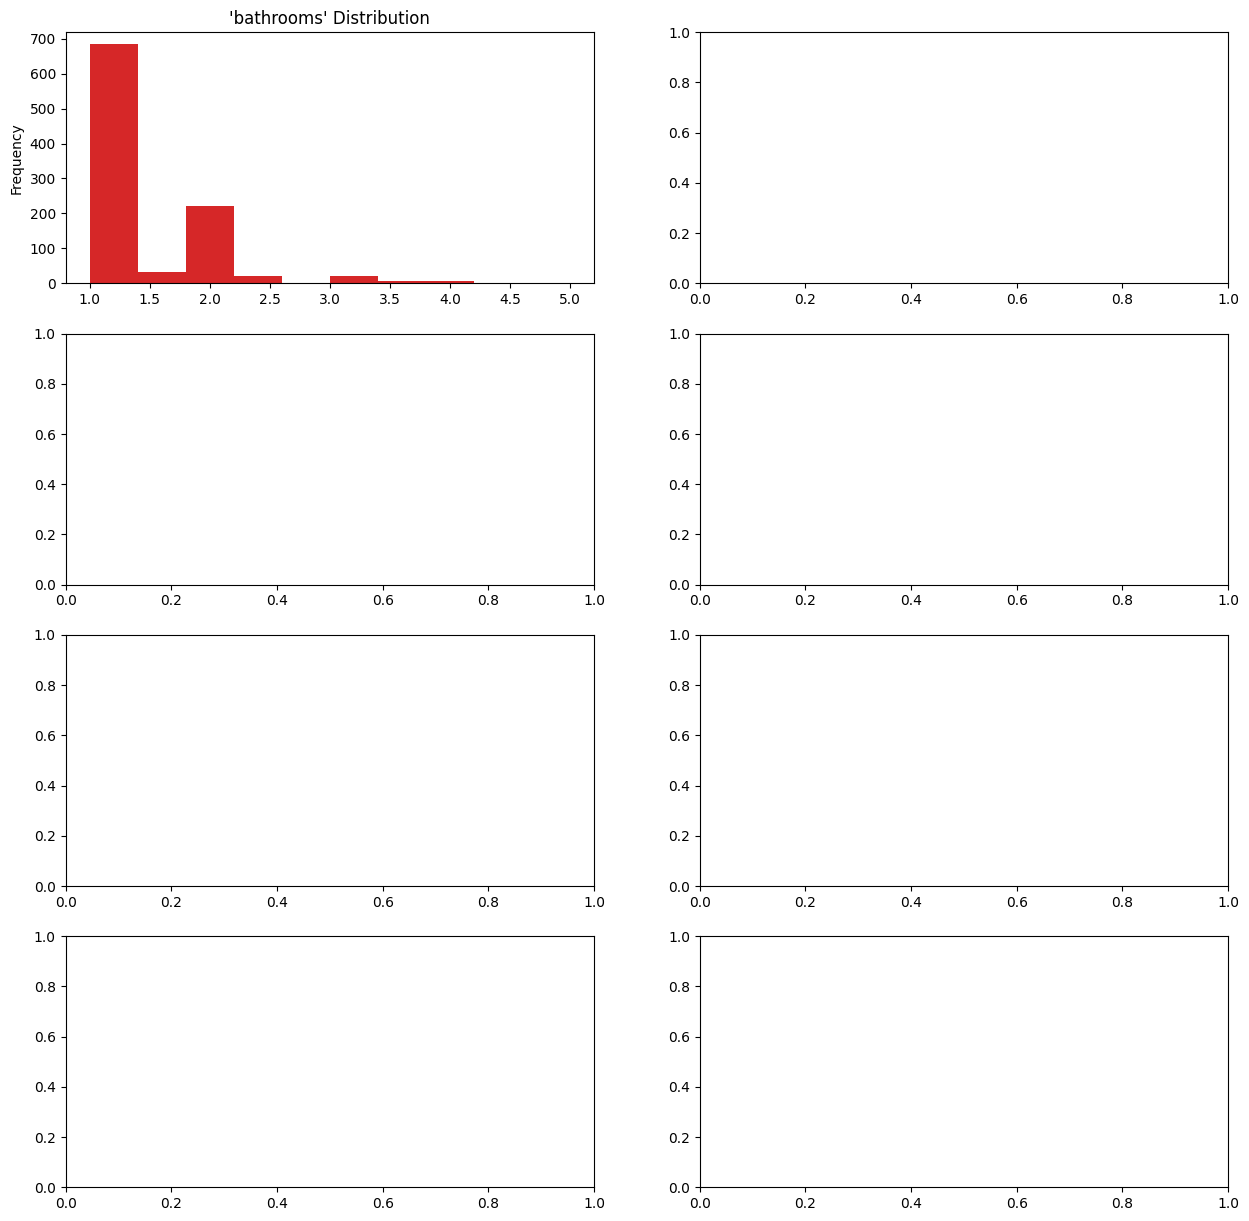

In [9]:
''' 
    Plot Distributions (histograms) of each continuous feature
'''

fig,axs = plt.subplots(4,2, figsize=(15,15))

df['bathrooms'].plot(kind="hist",ax=axs[0,0])
axs[0,0].set_title("'bathrooms' Distribution")

df['bathrooms'].plot(kind="hist",ax=axs[0,0])
axs[0,0].set_title("'bathrooms' Distribution")

df['bathrooms'].plot(kind="hist",ax=axs[0,0])
axs[0,0].set_title("'bathrooms' Distribution")

df['bathrooms'].plot(kind="hist",ax=axs[0,0])
axs[0,0].set_title("'bathrooms' Distribution")

# 2 Data Pre-processing

Create Train/Test Split

In [ ]:
y = df['price'].copy()
X = df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=args.test_split, random_state=args.seed)

In [181]:
'''  
    Custom Estimators 
'''

class DropColumns(BaseEstimator, TransformerMixin):
    ''' 
        Drop : default, poutcome
    '''
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        return X_copy.drop(columns=self.columns_to_drop)

class ExplodeHotEncode(BaseEstimator, TransformerMixin):
    ''' 
        Explodes and onehot-encodes series type columns (values in series become separate binarized columns)
    '''

    def __init__(self, columns, sep=","):
        self.columns = columns
        self.sep = sep 
        self.encoders = {}
    
    def fit(self, X, y=None):
        X_copy = X.copy()
        for col in self.columns:
            token_lists = X_copy[col].astype(str).apply(lambda x: list(set(x.split(self.sep))) if not self.isNa(x) else [])

            mlb = MultiLabelBinarizer()
            mlb.fit(token_lists)
            self.encoders[col] = mlb
        return self
    
    def transform(self, X):
        X_copy = X.copy()

        for col in self.columns:
            token_lists = X_copy[col].astype(str).apply(lambda x: list(set(x.split(self.sep))) if not self.isNa(x) else [])
            mlb = self.encoders[col]
            transformed = mlb.transform(token_lists)
            df_transformed = pd.DataFrame(transformed, 
                                          columns=[f"{col}__{cls}" for cls in mlb.classes_],
                                          index=X_copy.index)
            
            X_copy = pd.concat([X_copy, df_transformed], axis=1)
            
        X_copy = X_copy.drop(columns=self.columns)

        return X_copy
    
    def isNa(self, x) :
        return x.strip() == "" or x is None or x.lower() == "nan"
    
class HandleNaN(BaseEstimator, TransformerMixin):
    ''' 
        Standardizes missing values to np.nan type
    '''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X,):
        X_copy = X.copy()
        X_copy = X_copy.map(lambda x : x.lower().strip() if isinstance(x, str) else x)
        X_copy.replace('unknown', np.nan, inplace=True)
        X_copy.replace('nonexistent', np.nan, inplace=True)

        X_copy.ffill(inplace=True) 

        return X_copy
    

class EncodeStateToRegion(BaseEstimator, TransformerMixin):
    ''' 
        Reduces states to regions
    '''

    def __init__(self, column="state"):
        self.column = column

    def fit(self, X, y=None):


        
        return self
    
    def transform(self, X):
        X_copy = X.copy()

        D1 = ["CT", "ME", "MA", "NH", "RI", "VT"]
        D2 = ["NJ", "NY", "PA"]
        D3 = ["IL", "IN", "MI", "OH", "WI"]
        D4 = ["IA", "KS", "MN", "MO", "NE", "ND", "SD"]
        D5 = ["DE", "FL", "GA", "MD", "NC", "SC", "VA", "DC", "WV"]
        D6 = ["AL", "KY", "MS", "TN"]
        D7 = ["AR", "LA", "OK", "TX"]
        D8 = ["AZ", "CO", "ID", "MT", "NV", "NM", "UT", "WY"]
        D9 = ["AK", "CA", "HI", "OR", "WA"]

        self.choices = ["New_England","Mid_Atlantic","E_N_Central","W_N_Central","South_Atlantic",
            "E_S_Central","W_S_Central","Mountain","Pacific"]

        conditions = [
                    (X[self.column].isin(D1)),
                    (X[self.column].isin(D2)),
                    (X[self.column].isin(D3)),
                    (X[self.column].isin(D4)),
                    (X[self.column].isin(D5)),
                    (X[self.column].isin(D6)),
                    (X[self.column].isin(D7)),
                    (X[self.column].isin(D8)),
                    (X[self.column].isin(D9)),
                ]

        X_copy['region'] = np.select(conditions, self.choices)
        X_copy = X_copy.drop(columns=self.column)

        return X_copy
    

    
class EncodeCityPrice(BaseEstimator, TransformerMixin):
    ''' 
        For encoding cities into city price categories
        2 : high
        1 : med
        0 : low
    '''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        cities = X.groupby(['cityname'])[['price']].mean()

        # make a judgement of where to split into low medium high price cities
        self.high_cities = cities[cities['price']>2000].index
        self.low_cities = cities[cities['price']<1000].index
        # I'm going to say below <1000 is low and >2000 is high, 
        # you could use any other split you think is a good idea
        

        return self
    
    def transform(self, X):
        X_copy = X.copy()
        

        city_conditions = [
            (X_copy['cityname'].isin(self.high_cities)),
            (X_copy['cityname'].isin(self.low_cities)),
        ]
        city_choices = [2, 0]
        
        

        X_copy['cityprice'] = np.select(city_conditions, city_choices, default=1)

        X_copy = X_copy.drop(columns=["cityname", "price"])

        return X_copy   


class Binarize(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Convert all instances of "yes"/"success" and "no"/"failure" to numbers 1 and 0
        X_copy = X_copy.map(lambda x: 1 if x == 'yes' or x=='success' else (0 if x == 'no' or x=='failure'else x))

        return X_copy

In [ ]:
numerical_columns = ['id','bathrooms','bedrooms','square_feet','latitude','longitude','time']
categorical_columns = ['title','body','currency','price_display','address', 'pets_allowed','category','amenities','cityname','price']
onehot_columns = ['has_photo', 'price_type', 'source', 'state']

numerical_pipeline = Pipeline([
    ('drop', DropColumns(columns_to_drop=['id'])),
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('drop', DropColumns(columns_to_drop=['title','body','currency','price_display','address'])),
    ('binarize', Binarize()),
    ("handleNaN", HandleNaN()),
    ('explodeHotEncodeComma', ExplodeHotEncode(['amenities', 'pets_allowed'], ',')),
    ('explodeHotEncodeSlash', ExplodeHotEncode(['category'], '/')),
    ('encodeCityPrice', EncodeCityPrice())
])

onehot_pipeline = Pipeline([
    ("handleNaN", HandleNaN()),
    ('stateToRegion', EncodeStateToRegion()),
    ('onehot', OneHotEncoder(drop="first", handle_unknown='ignore'))
])


full_pipeline = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', categorical_pipeline, categorical_columns),
    ('onehot', onehot_pipeline, onehot_columns),
])

labelScaler = StandardScaler()

In [192]:
X_train_processed = full_pipeline.fit_transform(X_train)
X_test_processed = full_pipeline.transform(X_test)

y_train_processed = labelScaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_processed = labelScaler.transform(y_test.values.reshape(-1, 1))

/cs/home/jz75/Documents/ML/myenv/lib64/python3.9/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['doorman'] will be ignored
  warnings.warn(
/cs/home/jz75/Documents/ML/myenv/lib64/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/cs/home/jz75/Documents/ML/myenv/lib64/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# 3 Model Training and Predictions

## 3.1 Scikit Learn Regression Model

In [200]:
linear_regression = LinearRegression()
linear_regression.fit(X_train_processed, y_train)

lr_predictions_train = linear_regression.predict(X_train_processed)
linear_regression_mse_train = np.sqrt(mean_squared_error(y_train, lr_predictions_train))

lr_predictions_test = linear_regression.predict(X_test_processed)
linear_regression_mse_test = np.sqrt(mean_squared_error(y_test, lr_predictions_test))

In [201]:
print("Mean Squared Train Error : ", linear_regression_mse_train)
print("Mean Squared Test Error : ", linear_regression_mse_test)

Mean Squared Train Error :  586.8282389295725
Mean Squared Test Error :  713.4137266800616


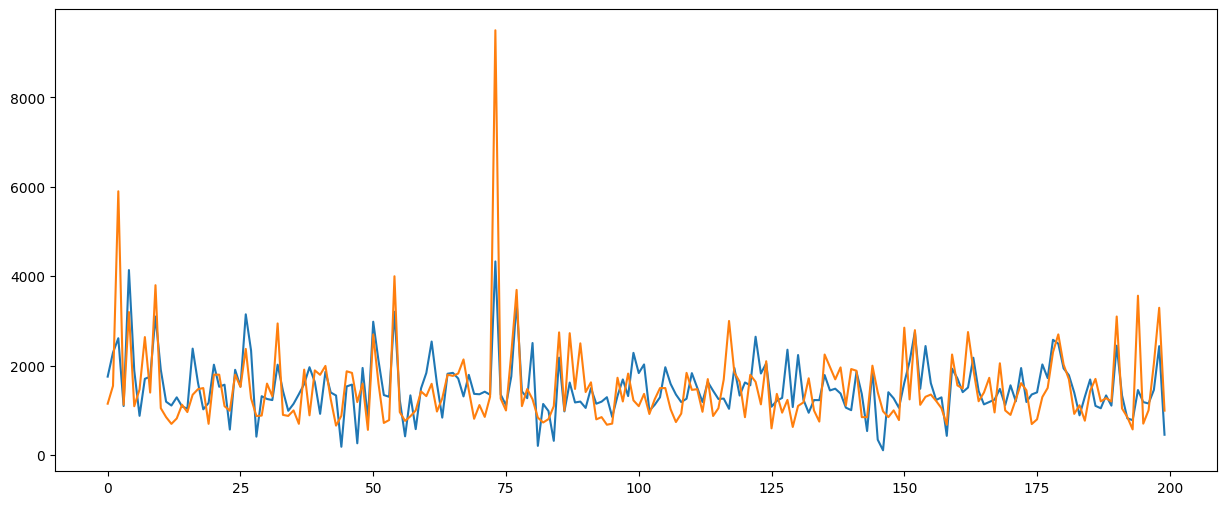

In [210]:
plt.figure(figsize=(15,6))

plt.plot([i for i in range(len(y_test))], lr_predictions_test)
plt.plot([i for i in range(len(y_test))], y_test)

In [208]:
sum(lr_predictions_test)/sum(y_test)

1.0036603750729014

## 2 Neural Network

### 2.1 Pytorch Dataset

In [260]:
class RegressionDataset(Dataset):
    ''' 
        Tensor dataset for torch NN training loop
    '''

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### 2.2 Neural Network Model

In [236]:
class RegressionModel(nn.Module):
    ''' 
        Basic NN implementation
    '''

    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 6),
            nn.ReLU(),
            nn.Linear(6, 1) # ensure single value output
        )

    def forward(self, x):
        return self.net(x)

## 2.3 Training 

### Initial Data Setup

### 2.3.1 Initialize Datasets & Dataloaders

In [264]:
train_ds = RegressionDataset(X_train_processed, y_train.values)
test_ds = RegressionDataset(X_test_processed, y_test.values)

In [265]:
train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=args.batch_size)

### 2.3.2 Initialize Model

In [266]:
model = RegressionModel(input_dim=X_train_processed.shape[1])

### 2.3.3 Optimizers and Loss Function

In [267]:
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=args.lr)

### 2.3.4 Training Loop

In [310]:
loss_per_epoch = []
loss_per_batch = []

for epoch in range(args.epochs):
    model.train()
    running_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        predictions = model(X_batch)

        loss = loss_fn(predictions, y_batch)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        loss_per_batch.append(loss.item())   

    loss_per_epoch.append(running_loss)


### 2.3.5 Evaluation

In [269]:
model.eval()
y_test_pred = model(torch.tensor(X_test_processed, dtype=torch.float32))

test_mse = loss_fn(y_test_pred, torch.tensor(y_test_processed.reshape(-1,1), dtype=torch.float32))

In [273]:
print("Test Mean Squared Error : ", np.sqrt(test_mse.detach().numpy()))

Test Mean Squared Error :  1592.8668


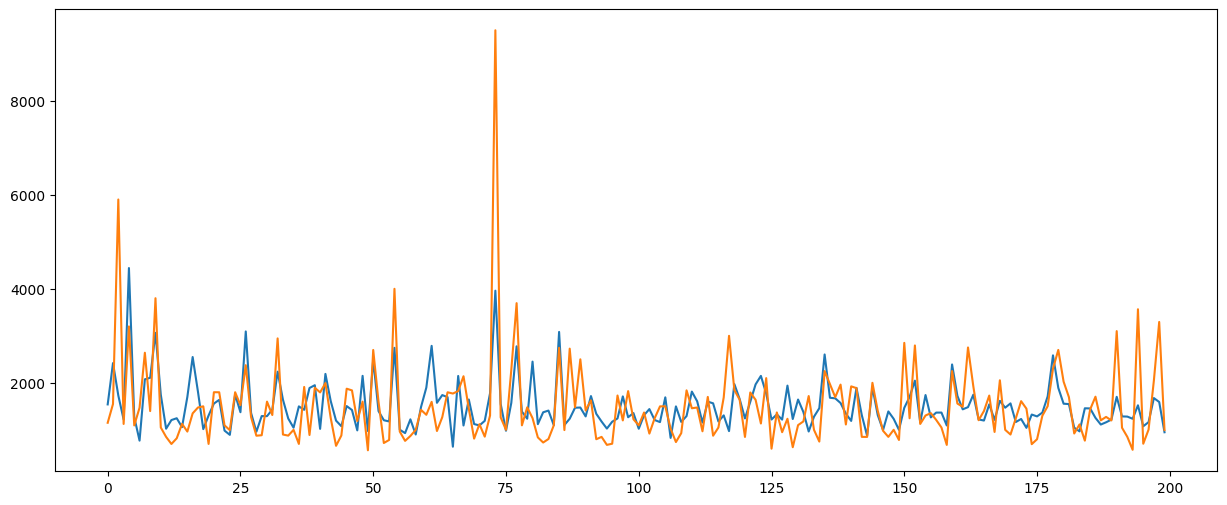

In [274]:
plt.figure(figsize=(15,6))

plt.plot([i for i in range(len(y_test))], y_test_pred.detach().numpy())
plt.plot([i for i in range(len(y_test))], y_test)

## 2.4 Full Implementation

In [ ]:
def train_model(model, train_loader, val_loader, test_loader):
    loss_fn = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    loss_per_epoch = []
    loss_per_batch = []

    for epoch in range(args.epochs):
        model.train()
        running_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            predictions = model(X_batch)

            loss = loss_fn(predictions, y_batch)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            loss_per_batch.append(loss.item())   

        loss_per_epoch.append(running_loss)

    return loss_per_epoch, loss_per_batch

In [ ]:
y = df['price'].copy()
X = df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=args.seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=args.val_split, random_state=args.seed)